In [1]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

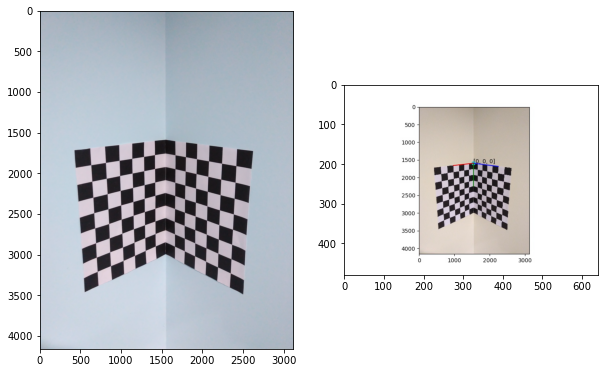

In [2]:
img = cv2.imread("../calibration-data/calib-object.jpg")
ref = cv2.imread("../calibration-data/calib-object-legend.jpg")
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121)
ax.imshow(img)
ax = fig.add_subplot(122)
ax.imshow(ref)

Image and world coordinates, found using interactive matplotlib

In [3]:
# Points calculated manually. 
N = 24

world_coord = np.array([[  0,   0 ,  0],
 [ 28,   0,   0],
 [ 56,   0,   0],
 [ 84,   0,   0],
 [112,   0,   0],
 [140,   0,   0],
 [168 ,  0,   0],
 [196,   0,   0],
 [  0,  28,   0],
 [  0,  56,   0,],
 [  0,  84,   0,],
 [  0, 112,   0,],
 [  0, 140,   0,],
 [  0, 168,   0,],
 [  0, 196,   0,],
 [  0, 224,   0,],
 [  0, 252,   0,],
 [  0,   0,  28,],
 [  0,   0,  56,],
 [  0,   0,  84,],
 [  0,   0, 112,],
 [  0,   0, 140,],
 [  0,   0, 168,],
 [  0,   0, 196,]])

img_coord = np.array([[1539, 1598],
 [1660, 1615],
 [1790 ,1626],
 [1932, 1650],
 [2086, 1663],
 [2236, 1685],
 [2429, 1718],
 [2606, 1745],
 [1544, 1766],
 [1538 ,1931],
 [1541, 2097],
 [1538, 2253],
 [1544, 2410],
 [1538, 2560],
 [1547, 2711],
 [1538, 2864],
 [1550, 2999],
 [1405, 1615], 
 [1284, 1625],
 [1134, 1636],
 [ 975, 1658],
 [ 800, 1677],
 [ 617 ,1705],
 [ 422 ,1729]])

# Helper functions

### DLT

DLT function as done in the class, <br>
A = [u_i,v_i]^T = [[x,y,z,1,0,0,0,0,-ux,-uy,-uz], [0,0,0,0,x,y,z,1,-vx,-vy,-vz]]^T <br>
then, UDV^T = SVD(A) <br>
now the projection matrix, P is the column of V corresponding to the smallest singular value of A

In [4]:
def DLT(img_coord, world_coord, N):
    A = []
    for i in range(N):
        u,v = img_coord[i][0], img_coord[i][1]
        x,y,z = world_coord[i][0], world_coord[i][1], world_coord[i][2]
        row1 = [-x,-y,-z,-1,0,0,0,0,u*x,u*y,u*z,u]
        row2 = [0,0,0,0,-x,-y,-z,-1,v*x,v*y,v*z,v]
        
        A.append(row1)
        A.append(row2)
    
    U, D, V = np.linalg.svd(A)
    P = V[np.argmin(D),:].reshape(3,4)
    return P

### Image Reconstruction

Reconstructing the image using the Projection matrix found by DLT and the world coordinates.

In [5]:
def reconstruct_img(img_coord, world_coord, P,N):
    X = np.empty((0,4), int)
    for i in range(N):
        wp = np.append(world_coord[i],1)
        wp = wp.reshape(1,4)
        X = np.append(X,wp,axis=0)
    img_pred = P@X.T  ## P - 3x4, X - Nx4
    
    ## img_pred is now 3xN matrix so we divide it by the last entry of the row, 
    ## i.e. img_pred = img_pred/img_pred[2]
    img_pred = img_pred[:2,:]/img_pred[2,:]
    
    ## finding the error in original image coordinates and the predicted image coordinates
    error = np.linalg.norm(img_pred.T-img_coord)
    
    return error, img_pred.T

### Normalization

In [6]:
def normalize_datapts(img_coord, world_coord):
    img_x_bar, img_y_bar = np.mean(img_coord[:,0]), np.mean(img_coord[:,1])
    d = np.mean(np.sqrt(np.sum((img_coord - np.array([img_x_bar,img_y_bar]))**2,axis=1)))
    
    world_x_bar = np.mean(world_coord[:,0])
    world_y_bar = np.mean(world_coord[:,1])
    world_z_bar = np.mean(world_coord[:,2])
    D = np.mean(np.sqrt(np.sum((world_coord - np.array([world_x_bar,world_y_bar,world_z_bar]))**2,axis=1)))
    
    T = np.array([
        [np.sqrt(2)/d,0,-np.sqrt(2)*img_x_bar/d],
        [0,np.sqrt(2)/d,-np.sqrt(2)*img_y_bar/d],
        [0,0,1]
    ])
    
    U = np.array([
        [np.sqrt(3)/D,0,0,-np.sqrt(3)*world_x_bar/D],
        [0,np.sqrt(3)/D,0,-np.sqrt(3)*world_y_bar/D],
        [0,0,np.sqrt(3)/D,-np.sqrt(3)*world_z_bar/D],
        [0,0,0,1],
    ])
    
    return T,U

### Rotation matrix

In [7]:
def getRotationMat(r):
    R_x = np.array([[1,0,0], [0,math.cos(r[0]),-math.sin(r[0])], [0,math.sin(r[0]),math.cos(r[0])]])
    R_y = np.array([[math.cos(r[1]),0,math.sin(r[1])], [0,1,0], [-math.sin(r[1]),0,math.cos(r[1])]])
    R_z = np.array([[math.cos(r[2]),-math.sin(r[2]),0], [math.sin(r[2]),math.cos(r[2]),0], [0,0,1]])
    
    R = np.dot(R_z,np.dot(R_x,R_y))
    return R


# Question 1

## Part 1

#### - For scale 28mm*28mm

### Part a) 

Performing DLT and Reconstruction on original data points

In [8]:
P_a = DLT(img_coord, world_coord,N)
print("Projection Matrix:\n",P_a)
error, img_pred = reconstruct_img(img_coord, world_coord, P_a, N)
print("Projection Error:")
print(error)

Projection Matrix:
 [[ 1.09095455e-03  2.88086902e-04 -2.81102249e-03  6.94068373e-01]
 [-5.85320686e-04  3.05603828e-03 -6.59619340e-04  7.19895546e-01]
 [-5.27664996e-07  1.79167936e-07 -5.55219253e-07  4.51200307e-04]]
Projection Error:
27.97226678173168


#### Plotting the original image points and the predicted image points

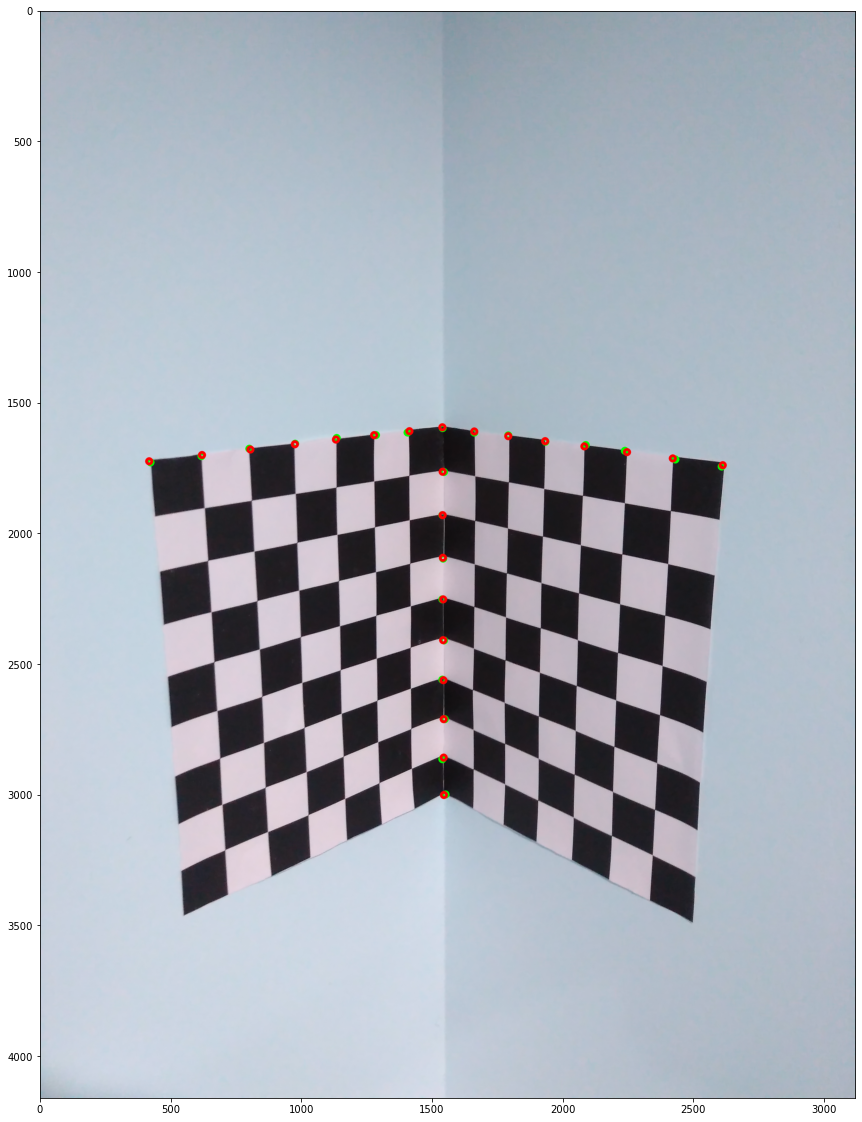

In [9]:
circ_img = img.copy()
for i in range(N):
    circ_img = cv2.circle(circ_img,tuple(img_coord[i]),10,[0,255,0],10) ## green specifies original points
    circ_img = cv2.circle(circ_img,tuple(map(int,img_pred[i])),10,[255,0,0],10) ## red are projected points
plt.figure(figsize=(20,20))
plt.imshow(circ_img)

### Finding normalized image and world coordinates

In [10]:
T,U = normalize_datapts(img_coord, world_coord)

img_coord_norm = np.concatenate((img_coord,np.ones((N,1))),axis=1)
for i in range(N):
    img_coord_norm[i,:] = T@img_coord_norm[i,:]
    img_coord_norm[i,:] = img_coord_norm[i,:]/img_coord_norm[i,-1]

world_coord_norm = np.concatenate((world_coord,np.ones((N,1))),axis=1)
for i in range(N):
    world_coord_norm[i,:] = U@world_coord_norm[i,:]
    world_coord_norm[i,:] = world_coord_norm[i,:]/world_coord_norm[i,-1]

### Part b)

DLT and Reconstruction on normalized data points, the error observed in this case is less than that of the original data points

In [11]:
P_b = DLT(img_coord_norm[:,:2],world_coord_norm[:,:3],N)
print("Projection Matrix:\n",P_b)
error, img_pred = reconstruct_img(img_coord_norm[:,:2], world_coord_norm[:,:3], P_b, N)
print("Projection Error:")
print(error)

Projection Matrix:
 [[ 0.39117471  0.00279211 -0.40332449  0.00371989]
 [ 0.09008836  0.55752381  0.08582489  0.05051847]
 [-0.0452123   0.01558683 -0.04764253  0.59233979]]
Projection Error:
0.0667541612355163


### Part c)

DLT on normalized data points then Reconstruction on the original data points

In [12]:
P_c = DLT(img_coord_norm[:,:2],world_coord_norm[:,:3],N)
P_c = np.linalg.pinv(T)@P_c@U
print("Projection Matrix:\n",P_c)
error, img_pred = reconstruct_img(img_coord, world_coord, P_c, N)
print("Projection Error:")
print(error)

Projection Matrix:
 [[ 1.52646234e+00  4.05553204e-01 -3.91209873e+00  9.66277041e+02]
 [-8.08702537e-01  4.26313695e+00 -9.13812558e-01  1.00213543e+03]
 [-7.31586346e-04  2.52212532e-04 -7.70910159e-04  6.28180184e-01]]
Projection Error:
27.92665959461874


#### - For scale 2800mm*2800mm

In [13]:

worldPoints = 100*np.array([[  0,   0 ,  0],
 [ 28,   0,   0],
 [ 56,   0,   0],
 [ 84,   0,   0],
 [112,   0,   0],
 [140,   0,   0],
 [168 ,  0,   0],
 [196,   0,   0],
 [  0,  28,   0],
 [  0,  56,   0,],
 [  0,  84,   0,],
 [  0, 112,   0,],
 [  0, 140,   0,],
 [  0, 168,   0,],
 [  0, 196,   0,],
 [  0, 224,   0,],
 [  0, 252,   0,],
 [  0,   0,  28,],
 [  0,   0,  56,],
 [  0,   0,  84,],
 [  0,   0, 112,],
 [  0,   0, 140,],
 [  0,   0, 168,],
 [  0,   0, 196,]])

### Part a) 

Performing DLT and Reconstruction on original data points

In [14]:
P_a = DLT(img_coord, world_coord,N)
error, img_pred = reconstruct_img(img_coord, world_coord, P_a, N)
print("Projection Matrix:\n",P_a)
print("Projection Error:")
print(error)


# [[-7.35581669e-06  3.06914382e-05 -2.54042744e-06 -6.95672180e-01]
#  [ 8.20793433e-06  1.08390583e-05 -2.96528161e-05 -7.18359252e-01]
#  [ 5.99692838e-09  7.05736050e-09 -1.62159696e-09 -4.48929902e-04]]

Projection Matrix:
 [[ 1.09095455e-03  2.88086902e-04 -2.81102249e-03  6.94068373e-01]
 [-5.85320686e-04  3.05603828e-03 -6.59619340e-04  7.19895546e-01]
 [-5.27664996e-07  1.79167936e-07 -5.55219253e-07  4.51200307e-04]]
Projection Error:
27.97226678173168


### Finding normalized image and world coordinates

In [15]:
T,U = normalize_datapts(img_coord, world_coord)

img_coord_norm = np.concatenate((img_coord,np.ones((N,1))),axis=1)
for i in range(N):
    img_coord_norm[i,:] = T@img_coord_norm[i,:]
    img_coord_norm[i,:] = img_coord_norm[i,:]/img_coord_norm[i,-1]

world_coord_norm = np.concatenate((world_coord,np.ones((N,1))),axis=1)
for i in range(N):
    world_coord_norm[i,:] = U@world_coord_norm[i,:]
    world_coord_norm[i,:] = world_coord_norm[i,:]/world_coord_norm[i,-1]

### Part b)

DLT and Reconstruction on normalized data points, the error observed in this case is less than that of the original data points

In [16]:
P_b = DLT(img_coord_norm[:,:2],world_coord_norm[:,:3],N)
print("Projection Matrix:\n",P_b)
error, img_pred = reconstruct_img(img_coord_norm[:,:2], world_coord_norm[:,:3], P_b, N)
print("Projection Error:")
print(error)

Projection Matrix:
 [[ 0.39117471  0.00279211 -0.40332449  0.00371989]
 [ 0.09008836  0.55752381  0.08582489  0.05051847]
 [-0.0452123   0.01558683 -0.04764253  0.59233979]]
Projection Error:
0.0667541612355163


### Part c)

DLT on normalized data points then Reconstruction on the original data points

In [17]:
P_c = DLT(img_coord_norm[:,:2],world_coord_norm[:,:3],N)
print("Projection Matrix:\n",P_c)
P_c = np.linalg.pinv(T)@P_c@U
error, img_pred = reconstruct_img(img_coord, world_coord, P_c, N)
print("Projection Error:")
print(error)

Projection Matrix:
 [[ 0.39117471  0.00279211 -0.40332449  0.00371989]
 [ 0.09008836  0.55752381  0.08582489  0.05051847]
 [-0.0452123   0.01558683 -0.04764253  0.59233979]]
Projection Error:
27.92665959461874


## Observations for 1st question - 
From  the above results we can see that normalization of points gives us better results by large factor. This is because the orginal data usually contains noise which gives rise to reprojection error. 

Data normilization hence gives better results as it gets rid of the noise. 

## 1.2

Calculating the Camera matrix, Rotation matrix and Camera center matrix

In [18]:
def KRC(P):
    M = P[:, :3]
    P4 = P[:, 3]
    
    C = -np.linalg.inv(M) @ P4
    q, r = np.linalg.qr(np.linalg.inv(M))
    R = q.T
    K = np.linalg.inv(r)
    K = K/K[2][2]
    return K, R, C

In [19]:
K,R,C = KRC(P_a)
print("Camera Matrix:")
print(K)
print("Rotation Matrix:")
print(R)

Camera Matrix:
[[3.46697719e+03 2.18718740e+01 1.67532539e+03]
 [0.00000000e+00 3.52784287e+03 1.97580936e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation Matrix:
[[-0.72311854  0.01057097  0.69064305]
 [-0.16476478 -0.97365897 -0.15760956]
 [ 0.67078472 -0.22776405  0.70581258]]


In [20]:
#rotated by PI
rotation = np.array([[-1,0,0],[0,-1,0],[0,0,1]])
new_rotationmatrix = R@rotation
new_cameramatrix = rotation@K

print("Old K times R")
print(R@K)
print("(New K' times R')")
print(new_rotationmatrix@new_cameramatrix)

Old K times R
[[-2507.0354936     21.47674757 -1189.88200023]
 [ -571.23572221 -3438.51957599 -2199.95673316]
 [ 2325.59533288  -788.8444437    674.47015852]]
(New K' times R')
[[-2507.0354936     21.47674757 -1189.88200023]
 [ -571.23572221 -3438.51957599 -2199.95673316]
 [ 2325.59533288  -788.8444437    674.47015852]]


When we look at the products of internal camera matrix and rotation matrix before and after transformation(rotation), are the same. We can conclude that the decomposition holds true even after the transformation applied. 

## Part 1.3

### RANSAC

#### Utility function for RANSAC

In [21]:
def RANSAC(img_coord, world_coord, N, iters = 200):
    threshold, sample_size = 20, 6
    ## threshold - error below which the point is considered as an inlier
    ## iters - no. of times points are sampled and checked
    ## sample_size - no. of points sampled each time
    
    ## RANSAC model finds the best Projection matrix for the given data points
    max_inliers, least_error, P_best = 0, 0, np.zeros((3,4))
    
    for i in range(iters):
        sample_index = np.random.choice(N,sample_size)
        sample_world_coord = world_coord[sample_index]
        sample_img_coord = img_coord[sample_index]
        
        P_temp = DLT(sample_img_coord, sample_world_coord, sample_world_coord.shape[0])
        
        inliers, sum_err = 0, 0
        for j in range(N):
            error, img_pred = reconstruct_img(img_coord[j].reshape(1,2), world_coord[j].reshape(1,3), P_temp, 1)
            sum_err += error
            if error<threshold:
                inliers+=1
        
        if inliers>max_inliers:
            max_inliers = inliers
            P_best = P_temp
            least_error = sum_err/N
    
    return least_error, max_inliers, P_best

### Part a)

In [22]:
least_error, max_inliers, P_best = RANSAC(img_coord,world_coord,N)
print("Least Projection error:")
print(least_error)
print("Maximum number of inliers:")
print(max_inliers)
print("Best projection matrix:")
print(P_best)

Least Projection error:
7.693409585465982
Maximum number of inliers:
23
Best projection matrix:
[[-1.32027681e-03 -3.61356619e-04  2.91563547e-03 -6.93259336e-01]
 [ 4.24407976e-04 -3.16215200e-03  8.79236155e-04 -7.20673268e-01]
 [ 4.51978103e-07 -2.06755834e-07  6.96955174e-07 -4.53911390e-04]]


### Part b) & c)

#### Number of iterations can be calculated as:
$k$ = $\log(1-P(success))$ / $\log(1-w^n)$ <br>
where, $P(success) = 0.95$, $w = 0.8$ and $n = 18$ <br>

Number of Iterations: 165.0


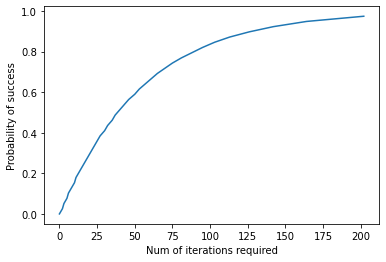

In [23]:
num_iters = np.ceil(np.log(1-0.95)/np.log(1-0.8**18))
print("Number of Iterations:", num_iters)

p = np.linspace(0,1,40)
num_iters = np.ceil(np.log(1-p)/np.log(1-0.8**18))

plt.plot(num_iters,p)
plt.xlabel('Num of iterations required')
plt.ylabel('Probability of success')
plt.show()

# Question 2

### Question 2 - Wire frame reconsturction function

In [24]:
def wireframe(rvecs,tvecs,mtx,l=8,m=6,mycam=0,num_images=15):
    x,y=np.meshgrid(range(l),range(m))
    if mycam==0:
        x=29*x
        y=29*y
    else:
        x=20*x
        y=20*y
    
    imageIndex=0
    world_points_1 = np.hstack(((x).reshape(l*m,1),(y).reshape(l*m,1),np.zeros((l*m,1)),np.ones((l*m,1)))).astype(np.float32)
    for img in range(0,num_images):
        r =  rvecs[img]
        R = cv2.Rodrigues(r)[0]
        temp1 = np.zeros((3,4))
        temp1[0:3,0:3] = R[0:3,0:3]
        temp1[:,3] = tvecs[img][:,0]
        P = np.matmul(mtx,temp1)
        P = P/P[2,3]

        projected_points = []
        for i in range((l*m)):
            projection = np.matmul(P,np.transpose(world_points_1[i,:]))
            projection = projection/projection[2]
            projected_points.append(projection[0:2])
        projected_points = np.asarray(projected_points)

        ### Wireframe
        idx=[m+1]
        cumsum=m+1
        while cumsum < l*(m-1) :
            cumsum+=l
            idx.append(cumsum)
#         idx = [7,15,23,31,39,47]
#         idx1 = [8,17,26,35,44,53]
        
    
    
        q = 0
        p = 0
        for i in range(projected_points.shape[0]):
#             print(idx[q])
            if (i == idx[q]):
                q = q + 1
                continue
            plt.plot([projected_points[i][0],projected_points[i+1][0]],[projected_points[i][1],projected_points[i+1][1]],'go-')
        for i in range(9):
            i1 = i
            j =  i + l
            while(j < l*m):
                plt.plot([projected_points[i1][0],projected_points[j][0]],[projected_points[i1][1],projected_points[j][1]],'go-')
                i1 = j
                j = j + l
    #     plt.imshow(im)
        path="../calibration-data/"
        if mycam==0:
            image=cv2.imread(path+'IMG_'+str(5456+imageIndex)+ '.JPG')
            imMod=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            plt.imshow(imMod)
        
        imageIndex+=1
        plt.title('Wireframe from reprojected points')
        plt.show() 
        

### Zhangs method function

In [25]:


def zhang(l=8,m=6, mycam = 0,num_images=15):
    path='../calibration-data/'
    x,y=np.meshgrid(range(l),range(m))
    
    x=29*x
    y=29*y
    
    world_points=np.hstack(((x).reshape((l*m),1),(y).reshape((l*m),1),np.zeros(((l*m),1)))).astype(np.float32)
   
    _3d_points=[]
    _2d_points=[]
    
    for i in range(0,num_images):
        if mycam==0:
            im=cv2.imread(path+'IMG_' + str(5456+i) + '.JPG') 
        ret, corners = cv2.findChessboardCorners(im, (l,m))

        if ret: #add points only if checkerboard was correctly detected:
            _2d_points.append(corners) #append current 2D points
            _3d_points.append(world_points) #3D points are always the same

    plt.show()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(_3d_points, _2d_points, (im.shape[1],im.shape[0]), None, None)


    ret, cameraMatrix, dist, rvecs, tvecs = cv2.calibrateCamera(_3d_points, _2d_points, (im.shape[1],im.shape[0]), None, None)
    print("cameraMatrix=")
    print(cameraMatrix)
    return rvecs,tvecs,cameraMatrix
   

cameraMatrix=
[[1.36634773e+04 0.00000000e+00 3.33653656e+03]
 [0.00000000e+00 1.36813826e+04 1.49660118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


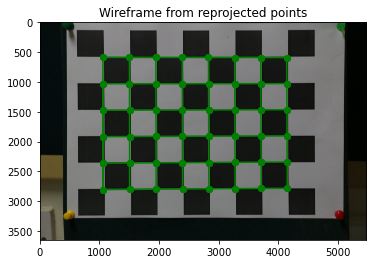

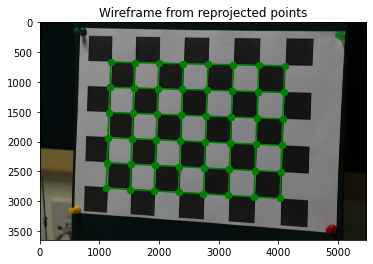

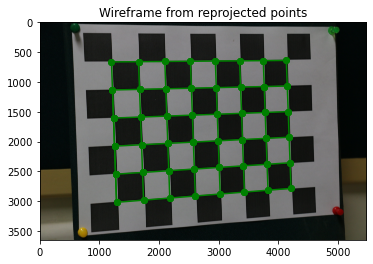

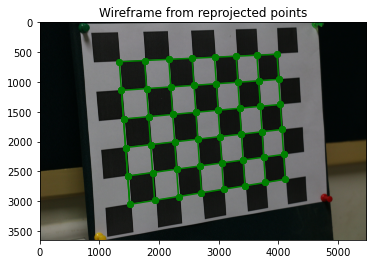

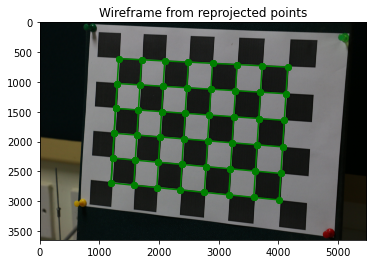

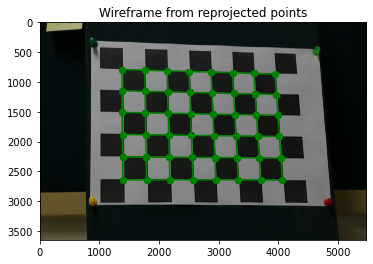

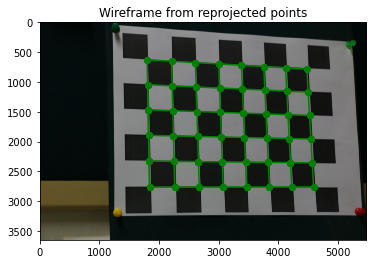

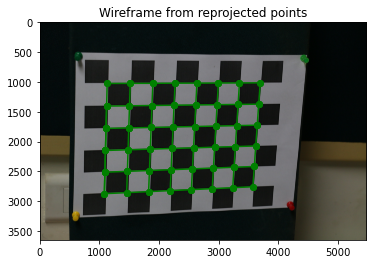

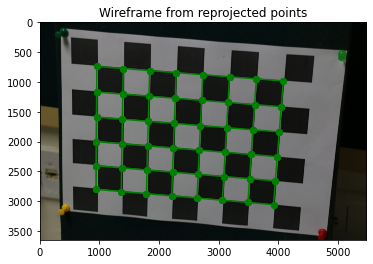

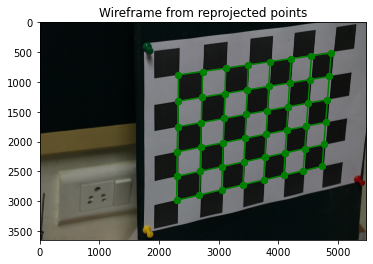

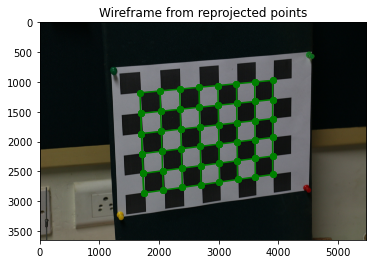

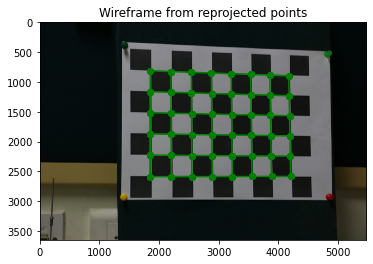

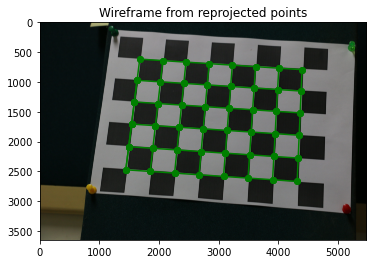

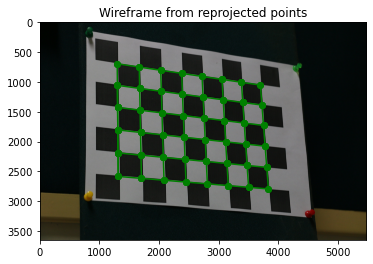

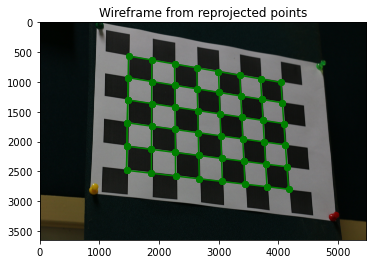

In [26]:
rvecs,tvecs,cameraMatrix=zhang()
wireframe(rvecs,tvecs,cameraMatrix)

When we look at the meshgrids on these images. We can see that that the mesh grid fits well when the images upright(flat) and at a lower angle (at right angle). If the meshgrid is on image that is turned by a large angle, the resuling meshing grid for the input of this image may result in error while estimating rotation and translation matrix. 

# Question 3

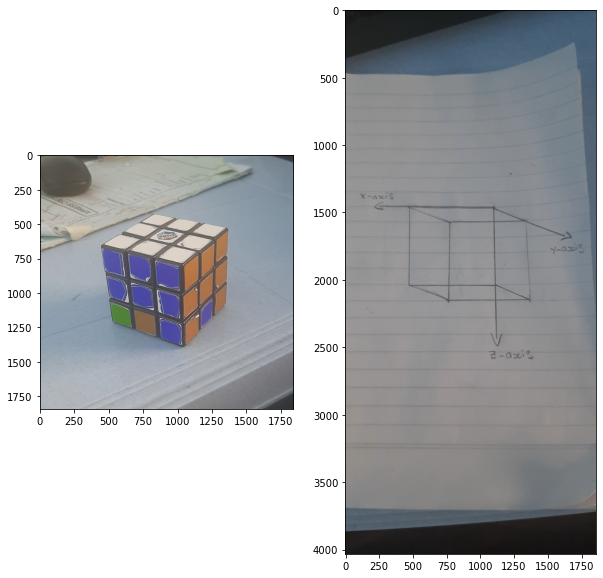

In [27]:
img = cv2.imread("../images/rubicsCube.jpg")
ref = cv2.imread("../images/rubicsAxis.jpg")
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121)
ax.imshow(img)
ax = fig.add_subplot(122)
ax.imshow(ref)

In [28]:
world_coord = np.array([[0,0,0],
             [0,3,0],
             [3,0,0],
             [3,3,0],
             [3,3,3],
             [3,0,3]])


img_coord = np.array([[829,433],
            [445,661],
            [1358,530],
            [1032,795],
            [1042,1377],
            [523,1207]])

## DLT

In [29]:
P_a = DLT(img_coord, world_coord,6)
error, img_pred = reconstruct_img(img_coord, world_coord, P_a, 6)
print("Projection Error:")
print(error)

Projection Error:
147.9421817116599


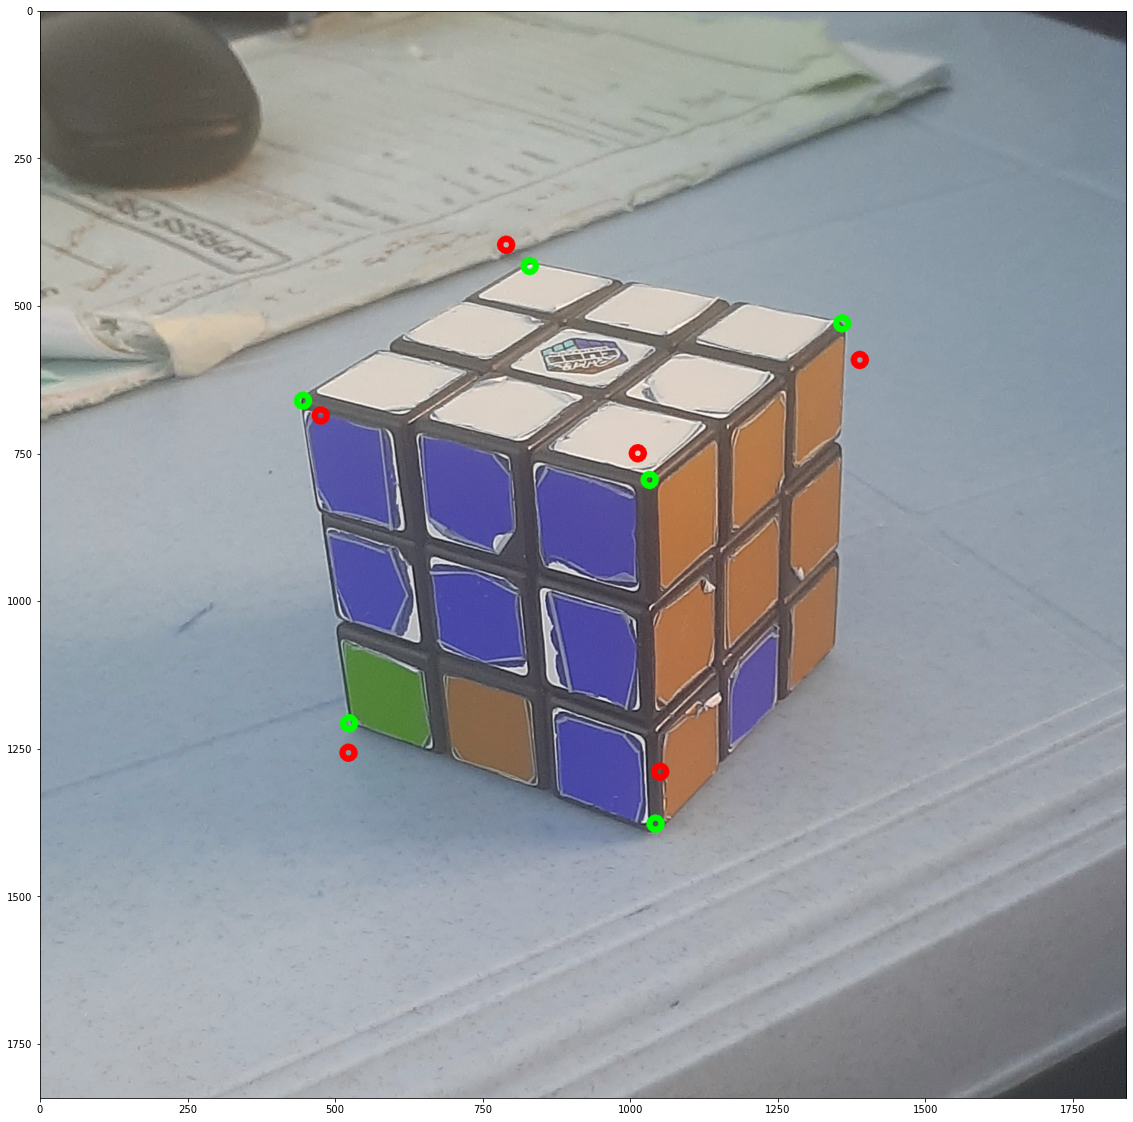

In [30]:
circ_img = img.copy()
for i in range(6):
    circ_img = cv2.circle(circ_img,tuple(img_coord[i]),10,[0,255,0],10)
    circ_img = cv2.circle(circ_img,tuple(map(int,img_pred[i])),10,[255,0,0],10)
plt.figure(figsize=(20,20))
plt.imshow(circ_img)

## RANSAC

In [31]:
least_error, max_inliers, P_best = RANSAC(img_coord,world_coord,6)
print("Least Projection error:")
print(least_error)
print("Maximum number of inliers:")
print(max_inliers)
print("Best projection matrix:")
print(P_best)

Least Projection error:
94.16903123311442
Maximum number of inliers:
5
Best projection matrix:
[[ 2.36845819e-02 -2.43030433e-02  3.43873568e-01  1.35741819e-01]
 [ 3.26933553e-03  7.47704093e-03  9.25785901e-01  7.09001298e-02]
 [-3.82071221e-06 -7.51486179e-06  7.38543077e-04  1.63741639e-04]]


### Comparing the results of DLT and RANSAC

- Error for DLT = 147.94 <br>
- Error for RANSAC = 9.928331275762523 <br> (Changes slightly in each run)
From the above values it is clear that RANSAC algorithm minimizes the reprojection error and better optimizes than least projection error. 